In [1]:
import sys
sys.path.append('../centroFlye_repo/scripts')

import os
from collections import Counter, defaultdict
import heapq
from copy import deepcopy
import re

import networkx as nx
import numpy as np
import pandas as pd
import scipy.stats as stats
import edlib

import matplotlib
%matplotlib inline 
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from utils.bio import read_bio_seq, write_bio_seqs, compress_homopolymer, RC
from ncrf_parser import NCRF_Report

%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams['figure.figsize'] = [10, 8]


Getting compressed DXZ1* 

In [3]:
data_dir = "../data"
centroFlye_results_dir = "../data/centroFlye_results"

In [4]:
dxz1_star_fn = os.path.join(centroFlye_results_dir, 'DXZ1_star', 'DXZ1_rc_star.fasta')
dxz1_star = read_bio_seq(dxz1_star_fn)
dxz1_star_hpc = compress_homopolymer(dxz1_star)
dxz1_star_hpc = dxz1_star_hpc[:-1]

dxz1_star_hpc_fn = os.path.join(centroFlye_results_dir, 'DXZ1_star', 'DXZ1_rc_star_hpc.fasta')
write_bio_seqs(dxz1_star_hpc_fn, {'DXZ1*_hpc': dxz1_star_hpc})


In [5]:
len(compress_homopolymer(dxz1_star))

1454

Running NCRF on the compressed assembly with compressed DXZ1*

In [6]:
centroFlye_assembly_fn = \
os.path.join(centroFlye_results_dir, "polishing1", "final_sequence_hpc_4.fasta")


In [7]:
centroFlye_ncrf_dir = \
os.path.join(centroFlye_results_dir, "polishing1", "NCRF_rc_star_hpc")


The results are pre-cached, but you can rerun them with uncommenting the following code

In [8]:
!python ../centroFlye_repo/scripts/run_ncrf_parallel.py \
    --reads {centroFlye_assembly_fn} \
    -t 1 \
    --outdir {centroFlye_ncrf_dir} \
    --repeat {dxz1_star_hpc_fn}


(1 alignment reported)


In [9]:
centroFlye_ncrf_fn = \
os.path.join(centroFlye_ncrf_dir, "report.ncrf")


In [10]:
centroFlye_ncrf = NCRF_Report(centroFlye_ncrf_fn)
centroFlye_ncrf = list(centroFlye_ncrf.records.values())[0]
mas = centroFlye_ncrf.get_motif_alignments()


In [11]:
len(dxz1_star_hpc)

1453

In [12]:
abnormal_units = \
[0, 117, 298, 332, 333, 334, 335, 338, 399, 544, 548, 564, 571, 576, 582, 624, 626, 640, 649, 669, 678, 697, 706, 947, 1173, 1177, 1185, 1197, 1199, 1201, 1203, 1215, 1218, 1347, 1348, 1349, 1350, 1484, 1509]


In [13]:
len(mas) - len(abnormal_units)

1471

In [14]:
def delete_gaps(mas, abnormal_units, remove_last=False):
    alignments = {}
    for i, ma in enumerate(mas):
        if i in abnormal_units:
            continue
        alignment = []
        for s1, s2 in zip(ma.r_al, ma.m_al):
            if s2 != '-':
                alignment.append(s1)
        if remove_last:
            alignment = alignment[:-1]
        alignment = ''.join(alignment)
        alignments[i] = alignment
            
    return alignments

In [15]:
alignments = delete_gaps(mas, abnormal_units)

In [16]:
write_bio_seqs(os.path.join(centroFlye_results_dir,
                            "polishing1","evolution.fasta"),
               alignments)

Percent identity

In [17]:
def mapNucl2Index(nucl):
    return {'A': 0, 'C': 1, 'G': 2, 'T': 3, '-': 4}[nucl]
    

In [18]:
def get_profile(alignments, alignment_len=len(dxz1_star_hpc)):
    profile = np.zeros((alignment_len, 5), dtype=int)
    for i, alignment in alignments.items():
        for pos, nucl in enumerate(alignment):
            profile[pos, mapNucl2Index(nucl)] += 1
    return profile

In [19]:
profile = get_profile(alignments)
perc_identity        = [profile[i][mapNucl2Index(dxz1_star_hpc[i])] / sum(profile[i])      for i in range(len(dxz1_star_hpc))]
perc_identity_nogaps = [profile[i][mapNucl2Index(dxz1_star_hpc[i])] / sum(profile[i][:-1]) for i in range(len(dxz1_star_hpc))]


In [20]:
np.mean(perc_identity), np.median(perc_identity)

(0.98827761124338731, 0.99796057104010882)

In [21]:
np.mean(perc_identity_nogaps), np.median(perc_identity_nogaps)

(0.99533101903001386, 1.0)

(array([ 0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1]),
 <a list of 10 Text yticklabel objects>)

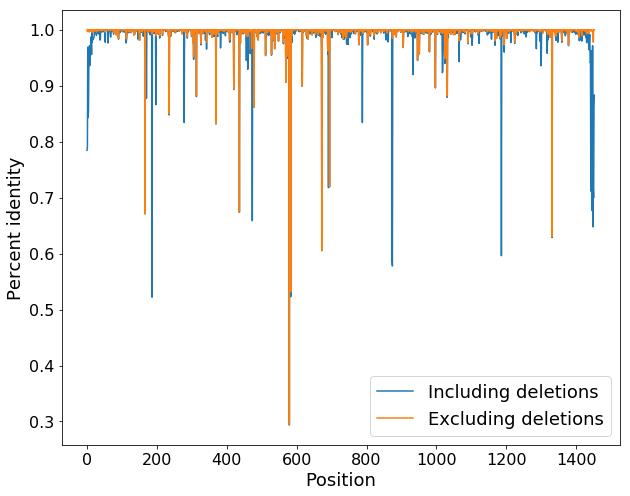

In [22]:
plt.plot(perc_identity)
plt.plot(perc_identity_nogaps)
plt.xlabel('Position', fontsize=18)
plt.ylabel('Percent identity', fontsize=18)
plt.legend(['Including deletions', 'Excluding deletions'], fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)       

In [23]:
profile_gapless = profile[:, :4]

Divergent positions

In [24]:
min_secondary_ratio = 0.3

In [25]:
def get_diverse_positions(profile, min_secondary_ratio=min_secondary_ratio):
    diverse_pos = []
    for i, profile_line in enumerate(profile):
        sorted_profile_line = sorted(deepcopy(profile_line))
        maj_vote_ind = 0
        while profile_line[maj_vote_ind] != sorted_profile_line[-1]:
            maj_vote_ind += 1
        sec_vote_ind = 0
        while profile_line[sec_vote_ind] != sorted_profile_line[-2]:
            sec_vote_ind += 1
        secondary_ratio = \
            sorted_profile_line[-2] / sorted_profile_line[-1]
        
        if secondary_ratio > min_secondary_ratio:
            # print(filt_pos[i], sorted_profile_line[-1], sorted_profile_line[-2])
            majority_freq = sorted_profile_line[-1] / sum(sorted_profile_line)
            secondary_freq = sorted_profile_line[-2] / sum(sorted_profile_line)
            diverse_pos.append((i, maj_vote_ind, sec_vote_ind, majority_freq, secondary_freq))
        
    return diverse_pos

In [26]:
divergent_pos = get_diverse_positions(profile_gapless)
len(divergent_pos), divergent_pos

(7,
 [(166, 3, 1, 0.67097212780421478, 0.32426920462270564),
  (436, 0, 1, 0.67460857726344448, 0.32471068754254595),
  (579, 0, 2, 0.70511945392491471, 0.29488054607508535),
  (583, 3, 2, 0.5318118948824343, 0.4681881051175657),
  (672, 1, 0, 0.60544217687074831, 0.39455782312925169),
  (694, 0, 2, 0.71972789115646263, 0.28027210884353743),
  (1331, 2, 3, 0.63053851397409677, 0.36946148602590323)])

In [27]:
def split_alignments_primitive(alignments, diverse_pos, min_dist=100, min_pvalue=0.05, verbose=True):
    split_pos, split_nucl, best_cm = None, None, None
    best_pvalue = min_pvalue
    pvalues = {}
    n_hypothesis = 0
    for pos1, _, _, _, _ in divergent_pos:
        for pos2, _, _, _, _ in divergent_pos:
            if pos1 <= pos2 - min_dist:
                n_hypothesis += 1
    for pos1, maj_vote1, sec_vote1, _, _ in diverse_pos:
        for pos2, maj_vote2, sec_vote2, _, _ in diverse_pos:
            if pos1 > pos2 - min_dist:
                continue
            cm = np.zeros((5,5))
            for al in alignments.values():
                nucl1 = mapNucl2Index(al[pos1])
                nucl2 = mapNucl2Index(al[pos2])
                cm[nucl1, nucl2] += 1
            # print(cm)
            # print(maj_vote1, sec_vote1)
            # print(maj_vote2, sec_vote2)
            cm = cm[[maj_vote1, sec_vote1], :]
            cm = cm[:, [maj_vote2, sec_vote2]]
            if np.any(np.sum(cm, axis=0) == 0) or np.any(np.sum(cm, axis=1) == 0):
                continue
            _, pvalue, _, _ = stats.chi2_contingency(cm)
            pvalue *= n_hypothesis
            pvalues[(pos1, pos2)] = pvalue
            if pvalue < best_pvalue:
                best_cm = cm
                split_pos = (pos1, pos2)
                best_pvalue = pvalue
                if np.sum(np.diag(cm)) <= np.sum(np.diag(cm[::-1])):
                    split_nucl = ((sec_vote1, maj_vote2),
                                  (maj_vote1, sec_vote2))
                else:
                    split_nucl = ((maj_vote1, maj_vote2),
                                  (sec_vote1, sec_vote2))
    if split_pos is None:
        return None, None, None


    alignments1, alignments2 = {}, {}
    for i, al in alignments.items():
        nucl1 = al[split_pos[0]]
        nucl2 = al[split_pos[1]]
        if mapNucl2Index(nucl1) == split_nucl[0][0] and \
            mapNucl2Index(nucl2) == split_nucl[0][1]:
            alignments1[i] = al
        elif mapNucl2Index(nucl1) == split_nucl[1][0] and \
            mapNucl2Index(nucl2) == split_nucl[1][1]:
        #else:
            alignments2[i] = al
    if verbose:
        print(split_pos)
        print(best_cm)
        print(best_cm / np.sum(best_cm))
        print(best_pvalue)
        print(len(alignments1), len(alignments2))
        print()

    return alignments1, alignments2, pvalues

In [28]:
_, _, pvalues = split_alignments_primitive(alignments, divergent_pos)
len(pvalues)

(579, 694)
[[ 1010.    23.]
 [   42.   389.]]
[[ 0.68989071  0.01571038]
 [ 0.02868852  0.26571038]]
3.10939595579e-253
1010 389



17

In [29]:
def get_divergent_pos_network(pvalues):
    divergent_pos_network = nx.Graph()
    for (pos1, pos2), pvalue in pvalues.items():
        if pvalue < 0.05:
            divergent_pos_network.add_edge(pos1, pos2, weight=pvalue)
    return ndex2.create_nice_cx_from_networkx(divergent_pos_network)

In [30]:
def split_alignments(alignments, min_size=100, max_iter=999):
    alignment_groups = [alignments]
    for i in range(max_iter):
        new_alignment_groups = []
        for i, alignment_group in enumerate(alignment_groups):
            print(len(alignment_groups))
            if len(alignment_group) >= min_size:
                filt_profile = get_profile(alignment_group)
                filt_profile = filt_profile[:, :4]
                diverse_pos = get_diverse_positions(filt_profile)
                print(f'# divergent positions: {len(diverse_pos)}')
                split_alignments1, split_alignments2, _ = split_alignments_primitive(alignment_group, diverse_pos)
                if split_alignments1 is not None and \
                        len(split_alignments1) >= min_size and \
                        len(split_alignments2) >= min_size:
                    new_alignment_groups.append(split_alignments1)
                    new_alignment_groups.append(split_alignments2)
                    print(i, len(alignment_group), len(split_alignments1), len(split_alignments2))
                else:
                    new_alignment_groups.append(alignment_group)        
            else:
                new_alignment_groups.append(alignment_group)
            
        if new_alignment_groups == alignment_groups:
            return alignment_groups
        alignment_groups = new_alignment_groups
    return alignment_groups


In [31]:
alignment_groups = split_alignments(alignments)

1
# divergent positions: 7
(579, 694)
[[ 1010.    23.]
 [   42.   389.]]
[[ 0.68989071  0.01571038]
 [ 0.02868852  0.26571038]]
3.10939595579e-253
1010 389

0 1471 1010 389
2
# divergent positions: 5
(166, 1331)
[[ 193.  429.]
 [ 310.   68.]]
[[ 0.193  0.429]
 [ 0.31   0.068]]
1.99144105435e-53
310 429

0 1010 310 429
2


/home/abzikadze/miniconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in long_scalars
  # This is added back by InteractiveShellApp.init_path()


# divergent positions: 3
(369, 616)
[[ 150.   59.]
 [  95.   78.]]
[[ 0.39267016  0.15445026]
 [ 0.2486911   0.20418848]]
0.0157266911702
150 78

3
# divergent positions: 8
(478, 583)
[[  36.  140.]
 [ 132.    2.]]
[[ 0.11612903  0.4516129 ]
 [ 0.42580645  0.00645161]]
1.36520537084e-40
132 140

0 310 132 140
3
# divergent positions: 2
(569, 672)
[[ 195.  128.]
 [  90.   16.]]
[[ 0.45454545  0.2983683 ]
 [ 0.20979021  0.03729604]]
0.000103701794905
90 128

3
# divergent positions: 3
(369, 616)
[[ 150.   59.]
 [  95.   78.]]
[[ 0.39267016  0.15445026]
 [ 0.2486911   0.20418848]]
0.0157266911702
150 78

4
# divergent positions: 4
(420, 1031)
[[ 72.  19.]
 [ 18.  20.]]
[[ 0.55813953  0.14728682]
 [ 0.13953488  0.15503876]]
0.0128112346889
72 20

4
# divergent positions: 9
(537, 689)
[[ 97.   2.]
 [  0.  41.]]
[[ 0.69285714  0.01428571]
 [ 0.          0.29285714]]
4.6599324383e-28
97 41

4
# divergent positions: 2
(569, 672)
[[ 195.  128.]
 [  90.   16.]]
[[ 0.45454545  0.2983683 ]
 [ 0.20

In [32]:
def plot_groups(alignment_groups):
    ax = plt.figure().gca()
    for i, group in enumerate(alignment_groups):
        keys = list(group.keys())
        plt.scatter(keys, np.zeros_like(keys) + i + 1, marker='|')
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xlabel('Units', fontsize=18)
    plt.ylabel('Subfamilies', fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(range(1,len(alignment_groups)+1), fontsize=16)
    plt.gca().invert_yaxis()
    plt.grid()

In [33]:
len(alignment_groups)

4

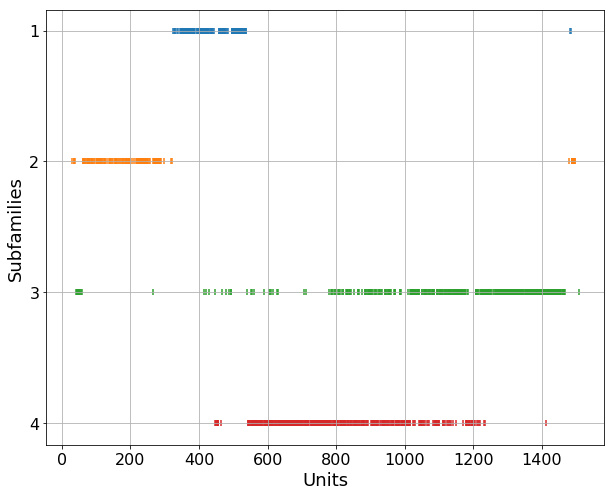

In [34]:
plot_groups(alignment_groups)

In [35]:
def get_consensus(alignment_groups):
    consensuses = {}
    for i, al_group in enumerate(alignment_groups):
        profile_group = get_profile(al_group)
        consensus = np.argmax(profile_group, axis=1)
        bases = list("ACGT-")
        consensus = [bases[i] for i in consensus]
        consensus = ''.join(consensus)
        consensuses[i] = consensus
    return consensuses

In [36]:
def DifferingPos(s1, s2):
    return [i for i in range(len(s1)) if s1[i] != s2[i] and s1[i] != '-' and s2[i] != '-']

In [37]:
consensuses = get_consensus(alignment_groups)
all_differing_pos = []
for i, c1 in consensuses.items():
    for j, c2 in consensuses.items():
        if i < j:
            differing_pos = DifferingPos(c1, c2)
            all_differing_pos += differing_pos
all_differing_pos = set(all_differing_pos)

In [38]:
for i, consensus in consensuses.items():
    print(i + 1, ' '.join([consensus[j] for j in all_differing_pos]))

1 C A G G C G G T C A G
2 C A A C C A T T C A A
3 C A A G T A G G A A A
4 A G A G T A T G A G A


In [39]:
for i, al_group in enumerate(alignment_groups):
    keys = list(al_group.keys())
    profile_group = get_profile(al_group)
    profile_group = profile_group[:, :4]
    divergent_pos_group = get_diverse_positions(profile_group)
    print(i, len(keys), len(divergent_pos_group))

/home/abzikadze/miniconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in long_scalars
  # This is added back by InteractiveShellApp.init_path()


0 132 4
1 140 9
2 429 2
3 389 3


# 7 divergent positions -- profile

In [40]:
divergent_pos

[(166, 3, 1, 0.67097212780421478, 0.32426920462270564),
 (436, 0, 1, 0.67460857726344448, 0.32471068754254595),
 (579, 0, 2, 0.70511945392491471, 0.29488054607508535),
 (583, 3, 2, 0.5318118948824343, 0.4681881051175657),
 (672, 1, 0, 0.60544217687074831, 0.39455782312925169),
 (694, 0, 2, 0.71972789115646263, 0.28027210884353743),
 (1331, 2, 3, 0.63053851397409677, 0.36946148602590323)]

In [41]:
def get_most_common_genotypes(alignments, divergent_pos, nclusters):
    divergent_pos_profile = []
    genotype_pos = defaultdict(list)
    for i, alignment in enumerate(alignments.values()):
        substr = tuple(alignment[pos[0]] for pos in divergent_pos)
        genotype_pos[substr].append(i)
        if '-' not in substr:
            divergent_pos_profile.append(substr)
    most_common_genotypes = Counter(divergent_pos_profile).most_common(nclusters)
    return genotype_pos, most_common_genotypes


In [42]:
genotype_pos, most_common_genotypes = get_most_common_genotypes(alignments, divergent_pos, 10)
most_common_genotypes = [most_common_genotypes[i] for i in [1, 2, 0, 4, 6, 7, 8, 3, 5, 9]]
most_common_genotypes


[(('T', 'A', 'G', 'T', 'A', 'G', 'G'), 198),
 (('C', 'C', 'A', 'G', 'C', 'A', 'T'), 123),
 (('T', 'A', 'A', 'G', 'C', 'A', 'G'), 211),
 (('T', 'A', 'G', 'T', 'C', 'G', 'G'), 86),
 (('C', 'C', 'A', 'T', 'A', 'A', 'T'), 44),
 (('C', 'A', 'G', 'T', 'A', 'G', 'G'), 42),
 (('C', 'C', 'A', 'T', 'C', 'A', 'T'), 41),
 (('T', 'A', 'A', 'G', 'A', 'A', 'G'), 112),
 (('T', 'C', 'A', 'T', 'C', 'A', 'T'), 66),
 (('C', 'A', 'A', 'T', 'C', 'A', 'T'), 39)]

In [43]:
def plot_genotype_pos(genotype_pos, selected_genotypes):
    ax = plt.figure().gca()
    for i, (genotype, count) in enumerate(selected_genotypes):
        keys = genotype_pos[genotype]
        plt.scatter(keys, np.zeros_like(keys) + i + 1, marker='|')
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xlabel('Units', fontsize=18)
    plt.ylabel('Subfamilies', fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(range(1,len(selected_genotypes)+1), fontsize=16)
    plt.gca().invert_yaxis()
    plt.grid()

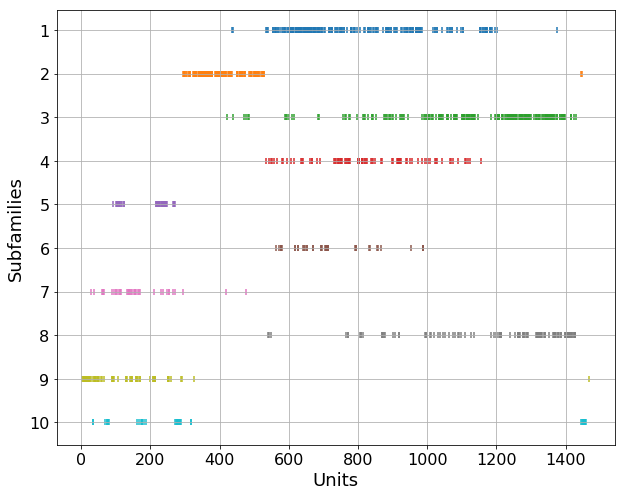

In [44]:
plot_genotype_pos(genotype_pos, most_common_genotypes)

# Comparison of clusters to gorilla

In [45]:
dxz1_gorilla_fn = os.path.join(data_dir, 'DXZ1_gorilla', 'X56887.1.fasta')
dxz1_gorilla = RC(read_bio_seq(dxz1_gorilla_fn))

In [46]:
dxz1_gorilla_double = dxz1_gorilla + dxz1_gorilla

dxz1_gorilla_double = compress_homopolymer(dxz1_gorilla_double)

human_gorilla_dxz1_align = edlib.align(dxz1_star_hpc, dxz1_gorilla_double, mode='HW', task='path')

In [47]:
def cigar2alignments(cigar, s1, s2):
    matches = re.findall(r'(\d+)([=XID]{1})', cigar)
    a1, a2 = [], []
    i1, i2 = 0, 0
    for length, mode in matches:
        length = int(length)
        if mode == '=':
            assert s1[i1:i1+length] == s2[i2:i2+length]
            substr = s1[i1:i1+length]
            a1.append(substr)
            a2.append(substr)
            i1 += length
            i2 += length
        elif mode == 'X':
            a1.append(s1[i1:i1+length])
            a2.append(s2[i2:i2+length])
            i1 += length
            i2 += length
        elif mode == 'I':
            a1.append(s1[i1:i1+length])
            a2.append('-' * length)
            i1 += length
        elif mode == 'D':
            a1.append('-' * length) 
            a2.append(s2[i2:i2+length])
            i2 += length
        else:
            assert False
    a1 = ''.join(a1)
    a2 = ''.join(a2)
    return a1, a2

In [48]:
dxz1_star_hpc_aligned, dxz1_gorilla_aligned = \
    cigar2alignments(human_gorilla_dxz1_align['cigar'],
                     dxz1_star_hpc,
                     dxz1_gorilla_double[human_gorilla_dxz1_align['locations'][0][0]:
                                         human_gorilla_dxz1_align['locations'][0][1] + 1])

In [49]:
def delete_gaps_dxz1_alignemnt(human, gorilla):
    human_upd, gorilla_upd = [], []
    for c1, c2 in zip(human, gorilla):
        if c1 != '-':
            human_upd.append(c1)
            gorilla_upd.append(c2)
    human_upd = ''.join(human_upd)
    gorilla_upd = ''.join(gorilla_upd)
    return human_upd, gorilla_upd

dxz1_star_hpc_aligned, dxz1_gorilla_aligned = \
delete_gaps_dxz1_alignemnt(dxz1_star_hpc_aligned, dxz1_gorilla_aligned)


In [50]:
for pos, _, _, _, _ in divergent_pos:
    print(dxz1_star_hpc_aligned[pos], dxz1_gorilla_aligned[pos])

T C
A A
G G
T -
C C
A G
G G


In [51]:
def HammingDistance(s1, s2):
    return len([i for i in range(len(s1)) if s1[i] != s2[i]])

In [52]:
gorilla_genotype = ''.join(dxz1_gorilla_aligned[pos] for pos, _, _, _, _ in divergent_pos)
for i, (genotype, cnt) in enumerate(most_common_genotypes):
    genotype = ''.join(genotype)
    print(i+1, genotype, HammingDistance(gorilla_genotype, genotype))

1 TAGTAGG 3
2 CCAGCAT 5
3 TAAGCAG 4
4 TAGTCGG 2
5 CCATAAT 6
6 CAGTAGG 2
7 CCATCAT 5
8 TAAGAAG 5
9 TCATCAT 6
10 CAATCAT 4
